# A lightweight package for generating random fields
This is the source repo for ```convolved-noise```, a small, efficient library for creating spatially correlated gaussian fields by convolving white noise with a smoothing kernel.

## Installation
The easiest way to access ```convolved-noise``` is though PyPI:
```
pip install convolved-noise
```

## Usage
Once ```convolved-noise``` is installed, use the line below to import its core method:

In [1]:
from cnvlnoise import noise

Calling ```noise()``` results in a numpy array containing the values of a gaussian process on a regular grid. The only non-optional argument is the shape of the grid. Any number of axes is permitted, although higher than 3D noise can be very expensive to generate. The example below is of 2D noise.

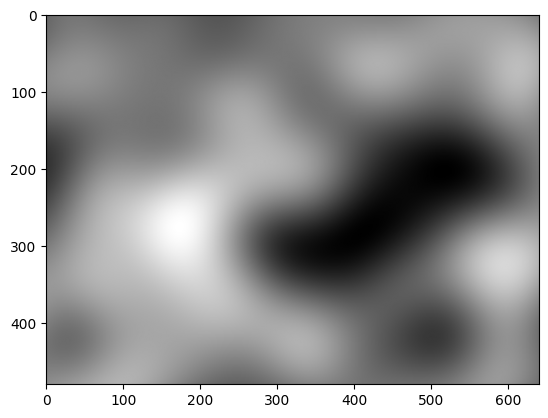

In [2]:
import matplotlib.pyplot as plt
plt.imshow(noise((480, 640)), cmap='gray')
plt.show()

### Changing the autocorrelation structure
Convolved noise is created by a discrete convolution of a white noise signal and a smoothing kernel. Currently, that kernel must be [radial](https://en.wikipedia.org/wiki/Radial_basis_function), specified by a radial function. By default, a gaussian kernel is used, but the user may pass their own broadcastable radial function too. For instance, the image below uses a cone-shaped smoothing kernel. The distances passed to the radial function are scaled so that the length of the noise image along its first axis is 1.

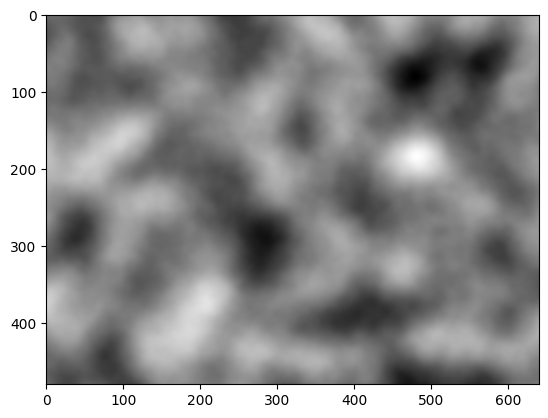

In [3]:
n = noise((480, 640), radial_func=lambda x: 0.1 - x)
plt.imshow(n, cmap='gray')
plt.show()

Interactions at distances larger than an effective range are ignored. If not specified, ```noise``` will attempt to infer this range with a binary search in (0, 1) for the distance at which the radial function drops below 0.0001. For many user-specified radial functions, this inference will fail, and the user must hardcode the desired range. For instance, a constant radial function must be truncated at some effective range.

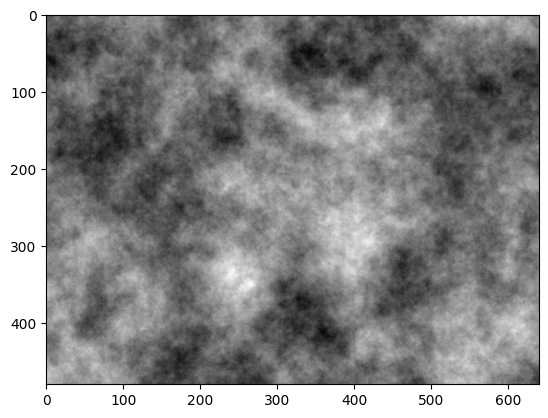

In [4]:
import numpy as np
n = noise((480, 640), radial_func=np.ones_like, eff_range=0.1)
plt.imshow(n, cmap='gray')
plt.show()

### Noise channels
A unique feature of ```noise``` is its support for multiple correlated channels. If a symmetric positive definite covariance matrix is passed for the optional ```channel_cov``` parameter, then instead of a standard normal variable at each grid point, the resulting sample will have a multivariate gaussian variable with mean zero and the resulting covariance. For instance, the color image below consists of a red, green, and blue channel which are each closely correlated.

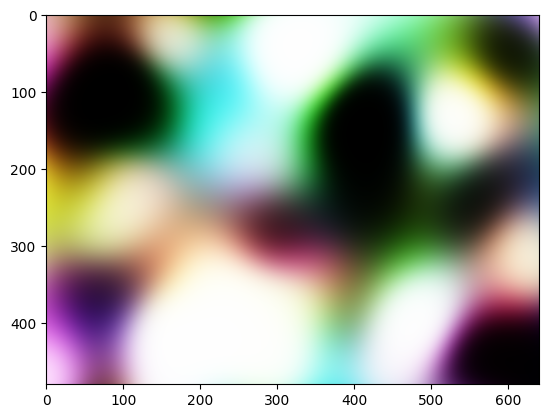

In [5]:
from scipy.special import erf
crg, crb, cgb = 0.9, 0.9, 0.9
rgb = noise((480, 640),
            channel_cov=np.array([
                [1, crg, crb],
                [crg, 1, cgb],
                [crb, cgb, 1]
            ]))
rgb = 0.5 * (1 + erf(rgb)) # use gaussian cdf to transform noise to [0, 1]
plt.imshow(rgb)
plt.show()

### Controlling periodicity
The ```periodic``` parameter can be a ```bool``` indicating whether to wrap the noise, or a tuple of ```bool```s indicating whether to wrap around each axis separately. For instance, the noise below is only wrapped around the vertical axis.

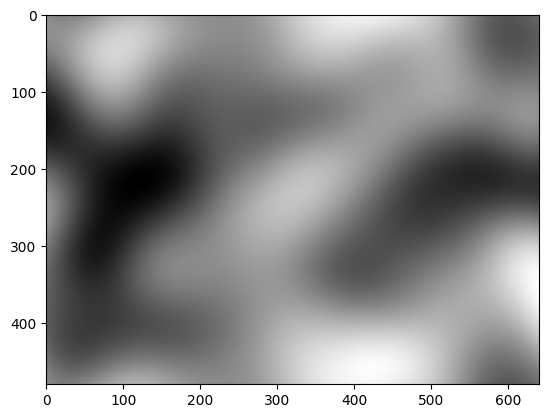

In [6]:
n = noise((480, 640), periodic=(True, False))
plt.imshow(n, cmap='gray')
plt.show()

### Reproducibility
Finally, the ```seed``` parameter is used as a random seed for the random sample. Note that using the same seed results in the same white noise sample, so similar structures sometimes appear even if the smoothing kernel is changed. This is demonstrated below with 1D noise.

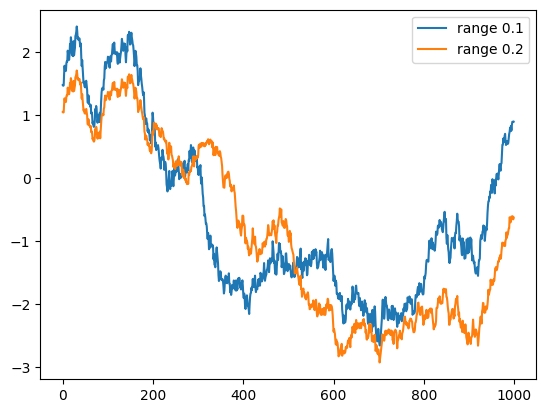

In [7]:
np1 = noise((1000,), radial_func=np.ones_like, eff_range=0.1, seed=0)
np2 = noise((1000,), radial_func=np.ones_like, eff_range=0.2, seed=0)
plt.plot(np1, label='range 0.1')
plt.plot(np2, label='range 0.2')
plt.legend()
plt.show()

## Timing comparison
The convolution algorithm used by ```convolved-noise``` is accelerated using the Fast Fourier Transform (FFT), and requires only $O(n\log n)$ operations, where $n$ is the number of grid points sampled. This makes convolution approximately as efficient as circulant embedding, another FFT-based random field generation algorithm which supports more general autocorrelation structures. A subtle difference illustrated below is that convolution's time complexity depends on the effective range of the kernel much more than that of circulant embedding. Circulant embedding is implemented in Python by the excellent ```parafields``` library. None of ```parafields```' parallelization capability is used below.

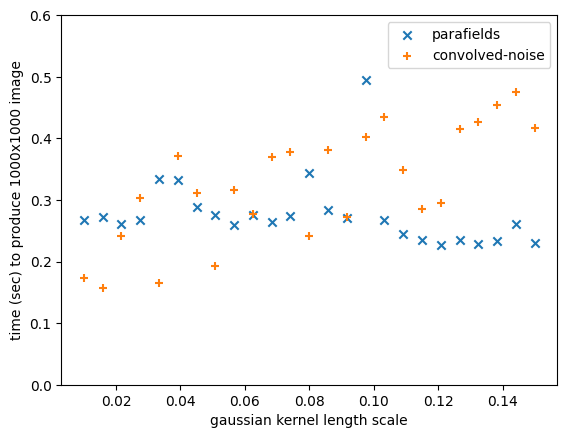

In [8]:
from parafields import generate_field
from time import time
scales = np.linspace(0.01, 0.15, 25)
dtpf, dtcn = [], []
for scale in scales:  # generate samples with the same autocorrelation using both libraries
    t0 = time()
    generate_field(cells=[1000, 1000], covariance="gaussian", corrLength=scale)
    dtpf.append(time() - t0)
    t0 = time()
    noise([1000, 1000], radial_func=lambda x: np.exp(-2 * (x / scale) ** 2))
    dtcn.append(time() - t0)
plt.scatter(scales, dtpf, marker='x', label='parafields')
plt.scatter(scales, dtcn, marker='+', label='convolved-noise')
plt.xlabel('gaussian kernel length scale')
plt.ylabel('time (sec) to produce 1000x1000 image')
plt.ylim([0, 0.6])
plt.legend()
plt.show()